In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/DePaul\ Research

/content/drive/MyDrive/DePaul Research


In [4]:
import json
import torch
import os
import torchvision
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import ImageDraw
from sklearn.metrics import classification_report
from tqdm import tqdm

In [5]:
with open('./D.json', 'rb') as f:
  d_detections = json.load(f)

with open('./J.json', 'rb') as f:
  j_detections = json.load(f)

with open('./R.json', 'rb') as f:
  r_detections = json.load(f)

with open('./S.json', 'rb') as f:
  s_detections = json.load(f)

In [6]:
labels = d_detections['detection_categories']
images = d_detections['images'] + j_detections['images'] + r_detections['images'] + s_detections['images']

In [7]:
len(images)

86313

In [8]:
df = pd.read_csv('updated_2018_detections')

In [9]:
def stratify_sample(df, inds_per_class):
  sample = df[df['ShortName'] != 'empty']
  
  # create running dictionary of indexes by class
  class_index = {}
  for label in sample['ShortName'].unique():
    class_index[label] = sample[sample['ShortName'] == label].index 

  # create sample index list with n inds_per_class 
  sample_inds = []
  for label, observations in class_index.items():
    if len(observations) > inds_per_class:
      class_sample = np.random.choice(observations, inds_per_class)
      sample_inds += list(class_sample)
    else:
      sample_inds += list(observations)

  # return sampled dataframe
  return df.iloc[sample_inds]

In [10]:
df['ShortName'].value_counts()

empty            55532
human             8822
squirrel          6998
raccoon           4884
bird              2069
w. t. deer        2010
e. cottontail     1687
dog               1459
v. opossum         861
coyote             722
striped skunk      211
cat                191
lawn mower         178
rat                136
Name: ShortName, dtype: int64

In [11]:
sample = df[df['Directory'].str.contains('D02')]
#sample = df[df['Directory'].str.contains('S0')]

In [12]:
sample['ShortName'].value_counts()

empty            5039
human             979
squirrel          454
dog               395
raccoon           314
e. cottontail     142
bird               92
cat                16
rat                10
coyote              8
v. opossum          7
lawn mower          1
Name: ShortName, dtype: int64

In [13]:
strat_sample = stratify_sample(df, 500)
sample_supplement = strat_sample[strat_sample['ShortName'].isin(['bird', 'cat', 'striped skunk', 'rat', 'v. opossum', 'w. t. deer'])]

In [14]:
#final_sample = sample.append(sample_supplement)
final_sample = sample.append(sample_supplement)

In [15]:
final_sample['ShortName'].value_counts()

empty            5039
human             979
bird              592
v. opossum        507
w. t. deer        500
squirrel          454
dog               395
raccoon           314
striped skunk     211
cat               207
rat               146
e. cottontail     142
coyote              8
lawn mower          1
Name: ShortName, dtype: int64

In [16]:
le = LabelEncoder()
final_sample['OneHotClass'] = le.fit_transform(final_sample['ShortName']) 

for i, class_name in enumerate(le.classes_):
  print(class_name, '==>', i)

bird ==> 0
cat ==> 1
coyote ==> 2
dog ==> 3
e. cottontail ==> 4
empty ==> 5
human ==> 6
lawn mower ==> 7
raccoon ==> 8
rat ==> 9
squirrel ==> 10
striped skunk ==> 11
v. opossum ==> 12
w. t. deer ==> 13


In [17]:
label_encoding = {
    0  : 'bird',
    1  : 'cat', 
    2  : 'coyote',
    3  : 'dog',
    4  : 'e. cottontail',
    5  : 'empty',
    6  : 'human',
    7  : 'lawn mower',
    8  : 'raccoon',
    9  : 'rat',
    10 : 'squirrel',
    11 : 'striped skunk',
    12 : 'v. opossum',
    13 : 'w. t. deer'
}

In [19]:
im_dict = {}

for im in images:
  try:
    filename = im['file'][40:]

    # check labels and ignore empty images
    if final_sample[final_sample['Directory'] == filename]['ShortName'].values[0] != 'empty':
    
      # only animals & people w high confidence
      detections = [x for x in im['detections'] if (x['conf'] > .9) & (x['category'] in ['1', '2'])]

      # if detection in image
      if detections != []:
        im_dict[filename] = {}
        im_dict[filename]['bbox'] = [x['bbox'] for x in detections]
        im_dict[filename]['detect_category'] = [x['category'] for x in detections]
        im_dict[filename]['label_name'] = final_sample[final_sample['Directory'] == filename]['OneHotClass'].values[0]
  except:
    # some images aren't included in our sample
    # so we pass
    pass

In [20]:
class WildlifeDataLoader(torch.utils.data.Dataset):
  def __init__(self, im_dict, transforms=None, root='./images'):
    self.root = root
    self.im_dict = im_dict
    self.transforms = transforms

    # grab all image file paths
    self.imgs = [file for file in im_dict.keys()]

  def __getitem__(self, idx):
    # open image and get dims
    img_path = os.path.join(self.root, self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    width, height = img.size

    # grab bbox and label
    try:
      box_labs = self.im_dict[self.imgs[idx]]['bbox']
      label = self.im_dict[self.imgs[idx]]['label_name']
    except:
      print(self.imgs[idx])
    num_objs = len(box_labs)
    boxes = []

    # de-normalize bbox coords from pre-detector model
    for i in range(num_objs):
      try:
        xmin = box_labs[i][0] * width
        ymin = box_labs[i][1] * height
        xmax = xmin + box_labs[i][2] * width
        ymax = ymin + box_labs[i][3] * height

        assert xmin>=0
        assert xmin<xmax
        assert ymin>=0
        assert ymin<ymax

        boxes.append([xmin, ymin, xmax, ymax])
      except Exception as e:
        print('Error: ', e, boxes)
        
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    # bit of a hack... only 1 class per pic but possibly multi-box
    labels = torch.tensor([label]*num_objs, dtype=torch.int64)
    image_id = torch.tensor([idx])
    
    # calculate box area
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
      
    return img, target

  def __len__(self):
    return len(self.imgs)

In [21]:
dataset = WildlifeDataLoader(im_dict)
dataset[0]

(<PIL.Image.Image image mode=RGB size=760x512 at 0x7FD5AA6DE150>,
 {'area': tensor([4305.9658]),
  'boxes': tensor([[381.3680, 312.3712, 439.6904, 386.2016]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([4])})

In [18]:
def get_instance_segmentation_model(num_classes, pretrained=True):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/build_docs/commit_docs.sh
	.circleci/regenerate.py
	.circleci/unittest/ios/scripts/binary_ios_build.sh
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run-clang-format.py
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	android/gradlew
	ios/build_ios.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
Please commit your changes or stash them before you switch branches.
Aborting


In [23]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # and ground-truth for data augmentation
        transforms.append(torchvision.transforms.RandomGrayscale())
    return T.Compose(transforms)

## TODO
- Setup Tensorboard training
- Build Evaluation Function
  - by class accuracy/precision etc

In [24]:
# use our dataset and defined transformations
dataset = WildlifeDataLoader(im_dict, get_transform(train=False))

split_ind = lambda train_percent: int(len(dataset) * train_percent)

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

dataset_train = torch.utils.data.Subset(dataset, indices[:split_ind(0.9)])
dataset_test = torch.utils.data.Subset(dataset, indices[split_ind(0.9):])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 14

# get the model using our helper function

#model = get_instance_segmentation_model(num_classes)
#model.to(device)

model = get_instance_segmentation_model(num_classes, pretrained=False)
model.load_state_dict(torch.load('./5_16.pth'))
model.to(device)

# construct an optimizer w/ OneCycle LR
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=0.0001)

num_epochs = 25

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
  # update the learning rate
  #lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/479]  eta: 0:13:50  lr: 0.000000  loss: 0.0625 (0.0625)  loss_classifier: 0.0296 (0.0296)  loss_box_reg: 0.0239 (0.0239)  loss_objectness: 0.0064 (0.0064)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.7337  data: 0.4804  max mem: 9337
Epoch: [0]  [ 50/479]  eta: 0:08:54  lr: 0.000011  loss: 0.0918 (0.0918)  loss_classifier: 0.0518 (0.0489)  loss_box_reg: 0.0407 (0.0390)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0020 (0.0024)  time: 1.2375  data: 0.0262  max mem: 9758
Epoch: [0]  [100/479]  eta: 0:07:51  lr: 0.000021  loss: 0.0949 (0.0941)  loss_classifier: 0.0488 (0.0490)  loss_box_reg: 0.0397 (0.0411)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0025 (0.0027)  time: 1.2382  data: 0.0265  max mem: 9758
Epoch: [0]  [150/479]  eta: 0:06:48  lr: 0.000032  loss: 0.1148 (0.1013)  loss_classifier: 0.0585 (0.0530)  loss_box_reg: 0.0496 (0.0441)  loss_objectness: 0.0007 (0.0015)  loss_rpn_box_reg: 0.0016 (0.0028)  time: 1.2368  data: 0.0261  max mem: 9758


In [30]:
torch.save(model.state_dict(), './5_16.pth')
print('model saved')

model saved


# Evaluate Model

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_instance_segmentation_model(14, pretrained=False)
model.load_state_dict(torch.load('./5_16.pth'))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

## Visualize Output

In [20]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    loader = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    image = Image.open(image_name)
    image = loader(image).float()
    return image.cuda()  #assumes that you're using GPU


def visualize_output_bw(im_path):
  """load image from im_path and call model
     visualize output w/ bounding box,  
     predicted class, and confidence """
  model.eval()
  with torch.no_grad():
      prediction = model([image_loader(im_path)])
  
  image = Image.open(im_path)

  # predicted bbox coords
  boxes = prediction[0]['boxes'][0].to('cpu').numpy()
  xmin = boxes[0]
  ymin = boxes[1]
  xmax = boxes[2]
  ymax = boxes[3]
  
  draw = ImageDraw.Draw(image)
  (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
                 (right, top), (left, top)], width=2, fill='red')
  
  # print predicted box label and confidence score
  print(le.inverse_transform(prediction[0]['labels'].to('cpu'))[0])
  print('Confidence: ', prediction[0]['scores'][0])
  return image

In [21]:
!pip install bounding_box

     |████████████████████████████████| 174kB 8.1MB/s 
  Created wheel for bounding-box: filename=bounding_box-0.1.3-cp37-none-any.whl size=163938 sha256=602f7de473a129f8413d1ef009ff853c70a70990c0b51ef815f6715102644e38
  Stored in directory: /root/.cache/pip/wheels/6a/6b/da/71d602e245ef4e78132ddf9b1fe445aca0f834d9216768a818
Successfully built bounding-box


In [22]:
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow

def visualize_output(im_path):
  model.eval()
  with torch.no_grad():
    prediction = model([image_loader(im_path)])
    
  bbox = prediction[0]['boxes'][0].to('cpu').numpy()
  label = le.inverse_transform([prediction[0]['labels'][0].to('cpu')])[0]
  score = prediction[0]['scores'][0].to('cpu').item()

  label = label + ': ' + str(np.round((score * 100), 2)) + '%'
  
  image = np.asarray(Image.open(im_path)).copy()
  bb.add(image, bbox[0], bbox[1], bbox[2], bbox[3], label, 'red')
  cv2_imshow(image)

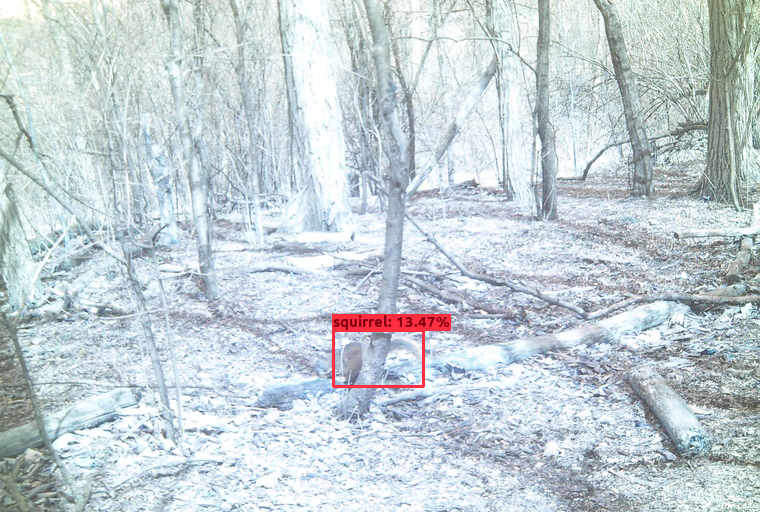

In [23]:
visualize_output('./images/R/R08/CHIL - R08-DAP1-AP18_00036.JPG')

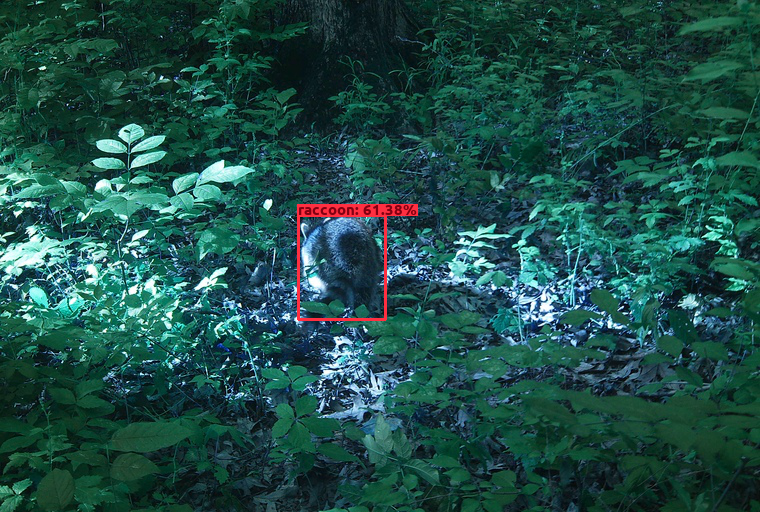

In [24]:
visualize_output('./images/S/S08/CHIL - S08-WGL1-JU18_00062.JPG')

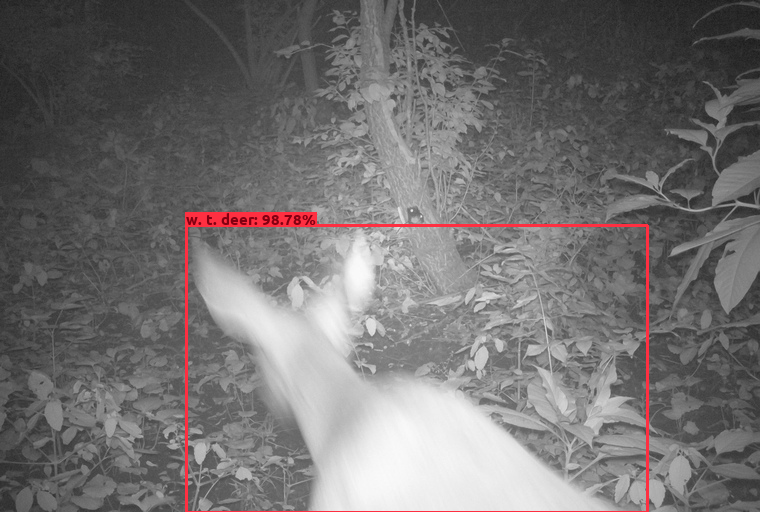

In [25]:
path = 'R/R07/CHIL - R07-GOF1-JU18_00075.JPG'
visualize_output(f'./images/{path}')

## Todo
- Draw all boxes over threshold (e.g. Human + Dog)
- Train on more V. Opposum, Cats, Coyote
- Trouble w Bird/Squirrel

In [26]:
def evaluate_performance(dataframe, threshold=0.5):
  preds = []
  actual = []
  ims = []
  confidence = []

  model.eval()
  for dir, act_lab in tqdm(dataframe[['Directory','ShortName']].values):
    with torch.no_grad():
      prediction = model([image_loader(f'./images/{dir}')])

    # catch instances w/ no predictions
    try:
      if prediction[0]['scores'][0] > threshold:
        pred_label = le.inverse_transform([prediction[0]['labels'][0].to('cpu')])[0]
        preds.append(pred_label)
        confidence.append(prediction[0]['scores'][0])
      else:
        preds.append('empty')
        confidence.append(prediction[0]['scores'][0])

    except:
      preds.append('empty')
      confidence.append(0)

    actual.append(act_lab)
    ims.append(dir)

  return preds, actual, ims, confidence

In [27]:
preds, actual, ims, confidence = evaluate_performance(df.sample(10000))

100%|██████████| 10000/10000 [1:17:22<00:00,  2.15it/s]


In [28]:
results = pd.DataFrame([ims, preds, actual, confidence]).T
results.columns = ['Image', 'Prediction', 'Actual', 'Confidence']

In [29]:
results[results['Actual'] == 'bird']

Image  ...                       Confidence
5     S/S03/CHIL - S03-JKP1-JU18_00101.JPG  ...                                0
27    S/S10/CHIL - S10-LPC1-JU18_00057.JPG  ...  tensor(0.9960, device='cuda:0')
94    J/J01/CHIL - J01-LMP1-AP18_00458.JPG  ...                                0
115   R/R05/CHIL - R05-GOC1-JU18_00206.JPG  ...                                0
123   R/R08/CHIL - R08-VLG1-AP18_00262.JPG  ...                                0
...                                    ...  ...                              ...
9670  D/D03/CHIL - D03-AFP1-AP18_00157.JPG  ...                                0
9713  R/R06/CHIL - R06-SLT1-JA18_00125.JPG  ...                                0
9756  D/D03/CHIL - D03-AFP1-AP18_00213.JPG  ...                                0
9877  S/S07/CHIL - S07-WGL2-JA18_00008.JPG  ...                                0
9961  D/D03/CHIL - D03-AFP1-AP18_00358.JPG  ...  tensor(0.7207, device='cuda:0')

[242 rows x 4 columns]

In [ ]:
results.to_csv('5_17_predictions.csv')

In [31]:
image = 'D/D03/CHIL - D03-AFP1-AP18_00332.JPG'
model.eval()
with torch.no_grad():
  prediction = model([image_loader(f'./images/{image}')])
prediction

[{'boxes': tensor([[ 70.0112, 302.2589, 188.4365, 396.4886],
          [ 76.4535, 272.4931, 236.6302, 394.6400],
          [ 58.7851, 292.4802, 178.6920, 396.0756]], device='cuda:0'),
  'labels': tensor([ 4, 10, 12], device='cuda:0'),
  'scores': tensor([0.2064, 0.0884, 0.0601], device='cuda:0')}]

e. cottontail
Confidence:  tensor(0.2064, device='cuda:0')


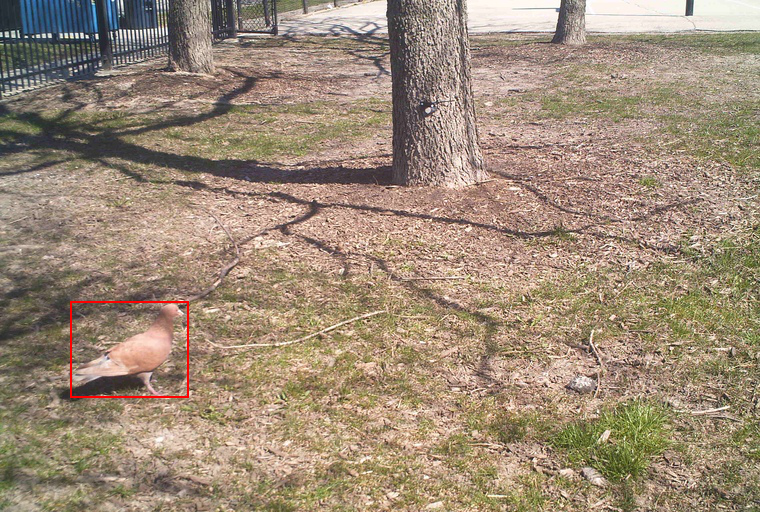

In [32]:
visualize_output_bw(f'./images/{image}')

In [31]:
from collections import Counter

Counter(preds)

Counter({'cat': 73,
         'dog': 270,
         'e. cottontail': 81,
         'empty': 6854,
         'human': 1176,
         'raccoon': 370,
         'rat': 27,
         'squirrel': 473,
         'striped skunk': 56,
         'v. opossum': 198,
         'w. t. deer': 422})

In [30]:
from sklearn.metrics import confusion_matrix

print(classification_report(actual, preds))

               precision    recall  f1-score   support

         bird       0.00      0.00      0.00       242
          cat       0.33      1.00      0.49        24
       coyote       0.00      0.00      0.00        85
          dog       0.41      0.63      0.50       175
e. cottontail       0.81      0.33      0.47       199
        empty       0.87      0.93      0.90      6462
        human       0.77      0.86      0.81      1057
   lawn mower       0.00      0.00      0.00        18
      raccoon       0.93      0.60      0.73       572
          rat       0.22      0.43      0.29        14
     squirrel       0.87      0.52      0.65       791
striped skunk       0.43      1.00      0.60        24
   v. opossum       0.42      0.85      0.56        98
   w. t. deer       0.52      0.92      0.66       239

     accuracy                           0.82     10000
    macro avg       0.47      0.58      0.48     10000
 weighted avg       0.81      0.82      0.80     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix

print(classification_report(actual, preds))

               precision    recall  f1-score   support

         bird       0.00      0.00      0.00       228
          cat       0.00      0.00      0.00        28
       coyote       0.94      0.45      0.61        97
          dog       0.78      0.62      0.69       175
e. cottontail       0.76      0.63      0.69       210
        empty       0.91      0.89      0.90      6500
        human       0.72      0.94      0.82      1016
   lawn mower       0.00      0.00      0.00        24
      raccoon       0.78      0.92      0.84       549
          rat       0.00      0.00      0.00        14
     squirrel       0.63      0.85      0.73       800
striped skunk       0.00      0.00      0.00        32
   v. opossum       0.00      0.00      0.00        88
   w. t. deer       0.87      0.87      0.87       239

     accuracy                           0.84     10000
    macro avg       0.46      0.44      0.44     10000
 weighted avg       0.82      0.84      0.82     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[5781  293  329   58    0   15   16    8    0    0    0    0    0    0]
 [  55  951    2    0    0    1    0    7    0    0    0    0    0    0]
 [ 105    3  683    1    0    0    7    1    0    0    0    0    0    0]
 [  40    0    2  503    0    2    2    0    0    0    0    0    0    0]
 [ 185    2   35    0    0    1    3    2    0    0    0    0    0    0]
 [  17    4    3    2    0  207    0    3    0    3    0    0    0    0]
 [  56    3   11    8    0    0  132    0    0    0    0    0    0    0]
 [  14   43    5    1    0    2    1  109    0    0    0    0    0    0]
 [  34    0    4   43    0    0    7    0    0    0    0    0    0    0]
 [  25    1    1    8    0   10    3    5    0   44    0    0    0    0]
 [  19    0    2   11    0    0    0    0    0    0    0    0    0    0]
 [   8    0    1   13    0    0    1    5    0    0    0    0    0    0]
 [   7   17    0    0    0    0    0    0    0    0    0    0    0    0]
 [  12    0    0    1    0    0    1    0    0    0

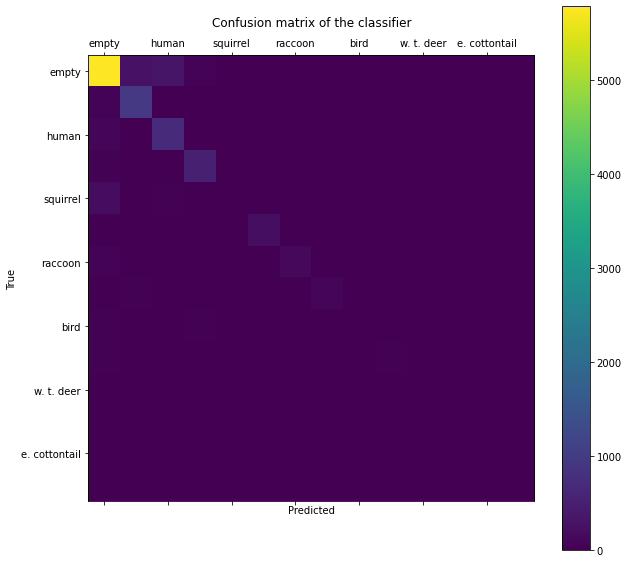

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ['empty','human','squirrel','raccoon','bird','w. t. deer','e. cottontail','dog','v. opossum','coyote','striped skunk','cat','lawn mower','rat']
cm = confusion_matrix(actual, preds, labels)
print(cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()